# Data Science Project 1 -  Improve the mass accuracy of spectra measured by Orbitrap mass spectrometers (orbitrap)

**Client:** Atmospheric Physical Chemistry group, INAR, University of Helsinki

**Description:** Motivation: When using a mass spectrometer, the measured mass usually shifts from its true mass. Hence, a mass calibration is an important procedure before allocating chemical formulae to the measured masses. A good mass calibration may greatly reduce the efforts of further analysis and increase the reliability of the results. Goals: Improve the mass calibration procedure for Orbitrap raw data, and perhaps for data measured by other mass spectrometers, e.g, TOF-MS Main tasks: 1) Test several fitting function for mass correction, and recommend one or a few that works best. 2) Test the performance of different parameters for mass correction, e.g., number of mass of the species for calibration.

**Data and tools:** Data: raw spectrum data measured by Orbitrap mass spectrometer. Tools: a) Orbitool, provided by the client. Orbitool will be used for reading the raw data and remove the noise, i.e., prepare the data for this analysis; b) Any programming language, which will be used to investigate this mass calibration problem.

## Environment

The environment should have the dependencies to run Orbitool and this notebook.

```bash
# Import environment
conda env create -f environment.yml

# Import kernel to jupyter
ipython kernel install --user --name=orbitool

# Export the environment to file
conda env export --no-builds > environment.yml
```

## Dependencies

In [4]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.signal as ss
from detecta import detect_peaks

## Data exploration

### Read the spectrum data

In [79]:
spectrum_data_directory = "data/CI-orbi_20201117165601 folder (first smal deviation file)/1 min"
peak_list_file = "peak list/peaklist_1e5_background.csv"
random_sample_size = None #Take sample spectrums to speed up things. If 'None' then uses all the spectrums
contains_time_data = False #Spectrum files contains time data in forst 3 rows?

spectrum_data_files = []
time_data = []
spectrum_data = []

# Get data files
for file in [f for f in listdir(spectrum_data_directory) if isfile(join(spectrum_data_directory, f))]:
    path_to_file = join(spectrum_data_directory, file)
    #print(path_to_file)
    if file.endswith(".csv"):
        spectrum_data_files.append(path_to_file)

# Take sample spectrums to speed up things
if random_sample_size:
    spectrum_data_files = random.sample(spectrum_data_files, random_sample_size)

# Read the spectrum files
for file in spectrum_data_files:
    if contains_time_data:
        time_data.append(pd.read_csv(file)[:2])
        spectrum_data.append(pd.read_csv(file, skiprows = 3).sort_values(by=['mz']))
    else:
        spectrum_data.append(pd.read_csv(file))

peak_list = dict(pd.read_csv(peak_list_file).values)

# Lookup
spectrum_data[0].head(5)

,mz,intensity
0,54.365898,0.000000
1,54.365921,2.150368
2,54.365945,14.089182
3,54.365969,26.112887
4,54.365993,29.565716


### Plot spectrums

0.11.1


<IPython.core.display.Javascript object>


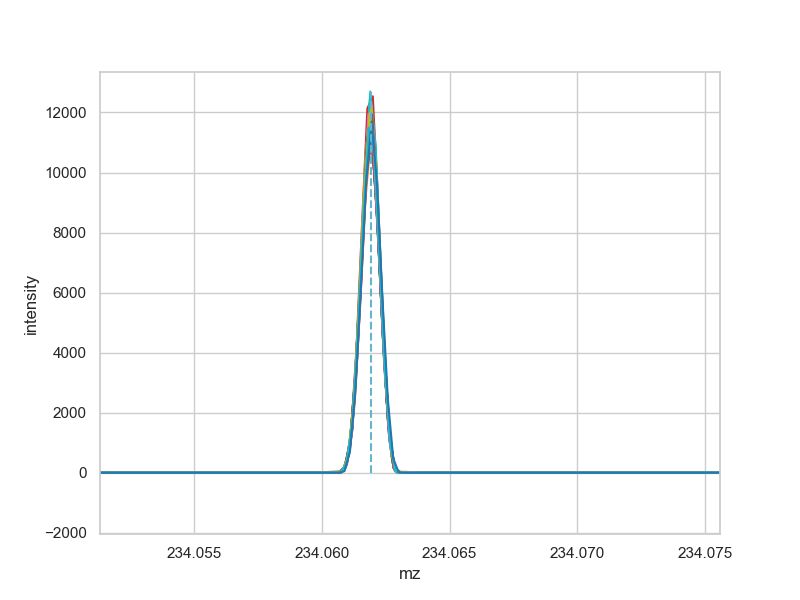

In [100]:
%matplotlib notebook
# seaborn version should be at least 0.11!
print(sns.__version__)

# Concat files to same data frame with 'spectrum' separator column
df = pd.concat(spectrum_data, keys=range(len(spectrum_data_files)), names=["spectrum"])

# Plot the spectrums
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=df, ax=ax, x="mz", y="intensity", hue="spectrum", palette="tab10")
ax.legend([],[], frameon=False)
ax.ticklabel_format(useOffset=False)

# Plot the actual masses. Line height is taken from max intensity with +-eps interval.
eps = 0.0001
for formula, mz in peak_list.items():
    max_intensity = max([x for x in df.loc[(df["mz"] > mz - eps) & (df["mz"] < mz + eps)].intensity.values] + [0.0])
    plt.plot((mz,mz), (0.0,max_intensity), linestyle="--")

### Find peaks

* [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)
* [peak-finding-algorithm-for-python-scipy](https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy)
* [overview-of-the-peaks-dectection-algorithms-available-in-python](https://pythonawesome.com/overview-of-the-peaks-dectection-algorithms-available-in-python/)

#### Notes 28.3.2021

* scipy's and jokinen's implementations have some parameters, so this comparison is not necessarily final!
* HO6N2- (124.98400933893943) scipy implementation worked best
* C8H10O8N- (248.04118986188942) jokinen's implementation worked best

Found peaks: 232
Length of data/peak categories: 3435 / 3435
Length of data/peak categories: 3435 / 3435
Length of data/peak categories: 3435 / 3435
Unique categories (jokinen): 232
Unique categories (koli): 242
Unique categories (scipy): 283


<IPython.core.display.Javascript object>


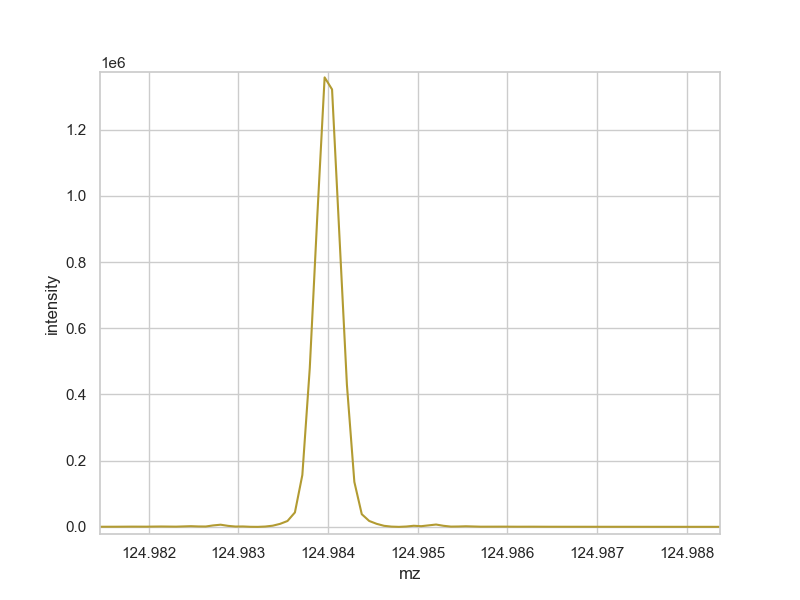

<IPython.core.display.Javascript object>


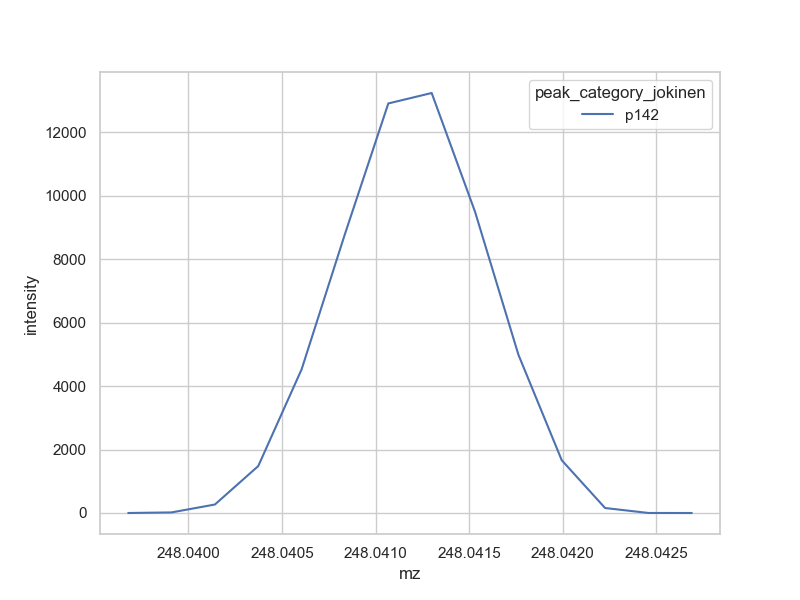

<IPython.core.display.Javascript object>


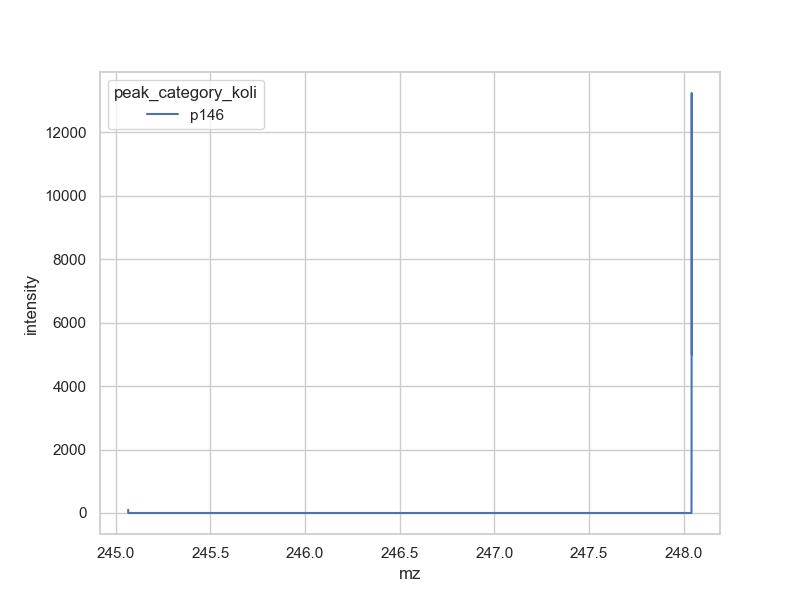

<IPython.core.display.Javascript object>


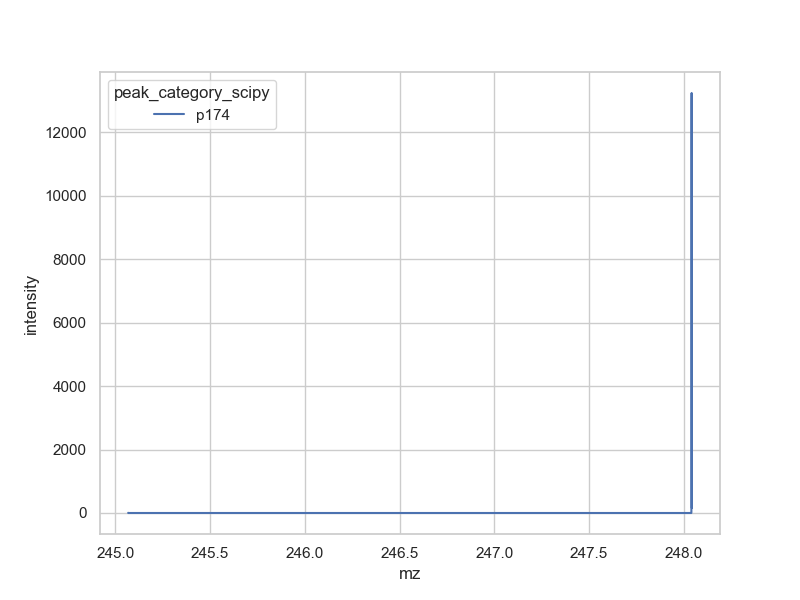

In [61]:
def find_peaks(x, y, theshold = 0.1, min_width = 3, min_heigth = 0.0):
    '''
    Categorize points to same peak with low variance; if a new data point increse the variance too much, 
    then classify it to new peak. Currently uses only 'x' (mz), but can be improved to take 'y' (intensity) into 
    account to compare derivates etc. Shortly this uses only distances of the peaks to separate them.
    '''
    indices = []
    curr_begin_i = 0
    last_x_var = 0
    for i in range(len(x)):
        curr_x_var = np.var(x[curr_begin_i:i])
        if last_x_var != 0 and i - curr_begin_i >= min_width and curr_x_var - last_x_var > last_x_var * theshold and max(y[curr_begin_i:i]) >= min_heigth:
            indices.append(i)
            curr_begin_i = i + 1
            last_x_var = 0
        last_x_var = curr_x_var
    print("Found peaks: {}".format(len(indices) + 1))
    return indices

def findPeakIndices(data):
    '''
    Koli's implementation.
    '''
    n = int(round(sum(data[:,1] == 0)/2))
    indices = np.zeros([n,2], dtype="uint32")
    a = False
    ii = 0
    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
    return indices

def create_categories_from_peaks(data, peaks):
    '''
    Creates categorical column to separate peaks. 'peaks' variable should be a list of 'starting points' of peak 
    intervals (0 index not needed).
    '''
    peak_categories = []
    last_peak_i = 0
    for i in range(len(peaks)):
        peak_categories += ["p{}".format(i)] * (peaks[i] - last_peak_i - 1)
        last_peak_i = peaks[i] - 1
    peak_categories += ["p{}".format(len(peaks))] * (len(data)-last_peak_i)    
    print("Length of data/peak categories: {} / {}".format(len(data), len(peak_categories)))
    return peak_categories

spectrum = 0 #Spectrum index to use

# Create peaks (lists of starting indices of the peaks)
peaks_jokinen = find_peaks(spectrum_data[spectrum]["mz"], spectrum_data[spectrum]["intensity"], theshold = 2.0, min_width = 3, min_heigth = 1)
peaks_koli = findPeakIndices(spectrum_data[spectrum].iloc[3:,:2].to_numpy().astype("float64"))[:,1] + 1 #Convert to starting points
peaks_scipy = ss.find_peaks(spectrum_data[spectrum]["intensity"]*-1, threshold = -10.0, width = 3, prominence = 1.0, distance = 5)[0]

# Apeend categorical columns to the dataframe (exmpl. p1, p2, ...)
spectrum_data[spectrum]["peak_category_jokinen"] = create_categories_from_peaks(spectrum_data[spectrum], peaks_jokinen)
spectrum_data[spectrum]["peak_category_koli"] = create_categories_from_peaks(spectrum_data[spectrum], peaks_koli)
spectrum_data[spectrum]["peak_category_scipy"] = create_categories_from_peaks(spectrum_data[spectrum], peaks_scipy)

# Print some data
print("Unique categories (jokinen): {}".format(len(spectrum_data[spectrum]["peak_category_jokinen"].unique())))
print("Unique categories (koli): {}".format(len(spectrum_data[spectrum]["peak_category_koli"].unique())))
print("Unique categories (scipy): {}".format(len(spectrum_data[spectrum]["peak_category_scipy"].unique())))

# Plot whole spectrum (discovered peaks are plotted with different colors, check 'hue' param)
fig, ax = plt.subplots(figsize=(8,6))
ax.ticklabel_format(useOffset=False)
sns.lineplot(data=spectrum_data[spectrum], ax=ax, x="mz", y="intensity", hue="peak_category_jokinen")
ax.legend([],[], frameon=False)

# Find and plot HO6N2- ion (124.98400933893943) with jokinen's peaks
fig, ax = plt.subplots(figsize=(8,6))
ax.ticklabel_format(useOffset=False)
sns.lineplot(data=spectrum_data[spectrum].loc[spectrum_data[spectrum]["peak_category_jokinen"] == "p142"], ax=ax, x="mz", y="intensity", hue="peak_category_jokinen")

# Find and plot HO6N2- ion (124.98400933893943) with koli's peaks
fig, ax = plt.subplots(figsize=(8,6))
ax.ticklabel_format(useOffset=False)
sns.lineplot(data=spectrum_data[spectrum].loc[spectrum_data[spectrum]["peak_category_koli"] == "p146"], ax=ax, x="mz", y="intensity", hue="peak_category_koli")

# Find and plot HO6N2- ion (124.98400933893943) with scipy's peaks
fig, ax = plt.subplots(figsize=(8,6))
ax.ticklabel_format(useOffset=False)
sns.lineplot(data=spectrum_data[spectrum].loc[(spectrum_data[spectrum]["peak_category_scipy"] == "p174")], ax=ax, x="mz", y="intensity", hue="peak_category_scipy")

<IPython.core.display.Javascript object>


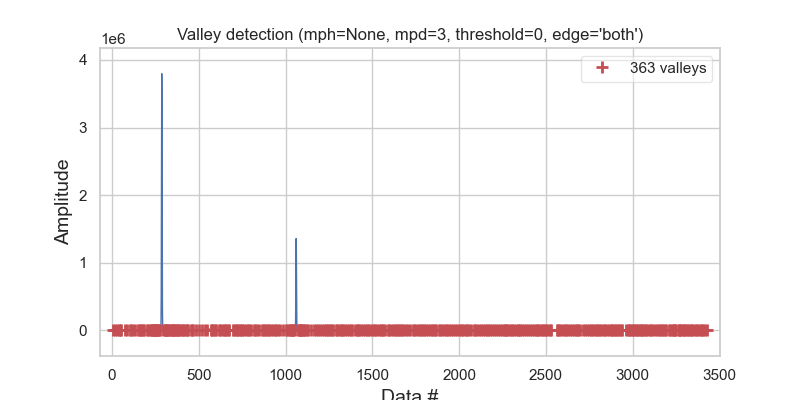

<IPython.core.display.Javascript object>


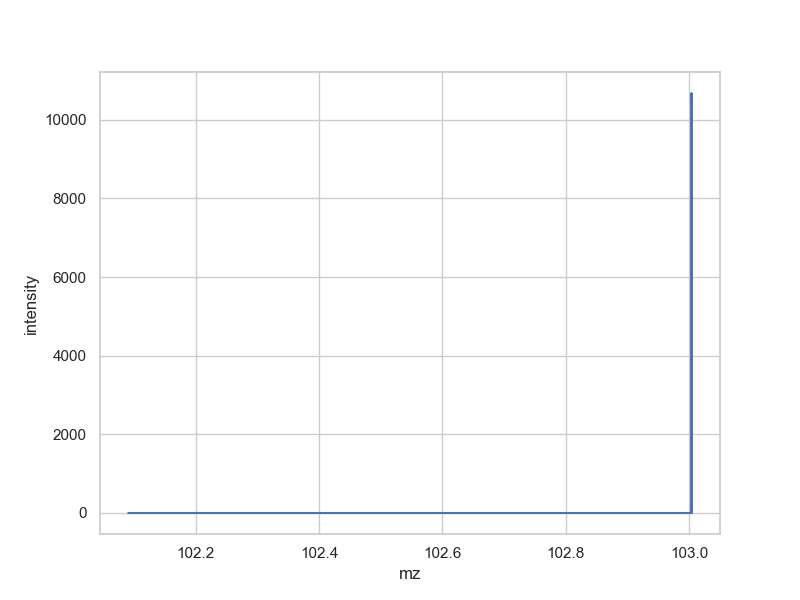

,mz,intensity
800,102.090571,0.000000
801,103.003183,0.000000
802,103.003245,8.412645
803,103.003307,19.272276
804,103.003369,25.789607
805,103.003431,46.083039
806,103.003493,260.455096
807,103.003555,1339.413998
808,103.003617,3996.853231
809,103.003679,7623.149430


In [119]:
spectrum = spectrum_data[0]#.loc[spectrum_data[0].intensity > 0.0] #Spectrum index to use

peaks_detecta = detect_peaks(spectrum["intensity"], mpd=3, valley=True, edge="both", show=True)

peaks = []
for i in range(len(peaks_detecta)):
    start = peaks_detecta[i-1] if i > 0 else 0
    end = peaks_detecta[i]
    data = spectrum.iloc[start:(end+1)]
    std = np.sqrt(np.var(data["mz"]))
    
    max_intensity = data["intensity"].max
    width = data["mz"].max() - data["mz"].min()
    average_mz = np.average(data["mz"], weights=data["intensity"])
    peaks.append({
        "start": start,
        "end": end,
        "max_intensity": max_intensity,
        "average_mz": average_mz,
        "width": width
    })
    
peak_information = pd.DataFrame(peaks)
peak = peak_information.iloc[(peak_information['average_mz']-peak_list["C3H3O4-"]).abs().argsort()[0]]

fig, ax = plt.subplots(figsize=(8,6))
ax.ticklabel_format(useOffset=False)
sns.lineplot(data=spectrum.iloc[peak["start"]:(peak["end"] + 1)], ax=ax, x="mz", y="intensity")
ax.legend([],[], frameon=False)

spectrum.iloc[(peak["start"]):(peak["end"] + 1)]